# Implementation of method MOMENT on inverter data
presented by Goswami et al.


In [31]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import torch

In [42]:
def getSMAData():
    path_errors = './errortimestamps.csv'
    path_features = './featureslist.csv'
    df_errors = pd.read_csv(path_errors)
    df_features = pd.read_csv(path_features)
    total_features = list(df_features[(df_features['True/False'] == 'TRUE') | (df_features['True/False'] == 'NotAvailable')]['Features'])
    tot_feat = pd.read_csv('./totfeat.csv')
    tot_feat = list(tot_feat['feat'])
    xtrain_dfs = {}
    xtest_dfs = {}
    ytrain_dfs = {}
    ytest_dfs = {}
    for inverter in range(19):
        inv = 'inv_'+str(inverter)
        tot_feat.append('ErrBits')
        df_inv_0 = pd.read_csv('./downsampledata/'+str(inverter)+'.csv')
        df_inv_0['Timestamp'] = pd.to_datetime(df_inv_0['Timestamp'])
        df_inv_0.sort_values(by='Timestamp', inplace=True)
        df_inv_0 = df_inv_0.set_index(df_inv_0['Timestamp'])
        df_inv_0.shape


        format = '%Y-%m-%d %H:%M:%S'
        error_date = datetime.strptime(df_errors[(df_errors['Inverter'] == inverter) & (df_errors['had_failure'] == True)]['failure_time'].values[0][0:19], format)
        start_date = error_date-timedelta(days= 60)
        end_date = error_date+timedelta(days= 1*30)
        split_date = error_date-timedelta(days= 1*30)

        df_inv_0 = df_inv_0[(df_inv_0.index > start_date) & (df_inv_0.index < end_date)]
        df_inv_0 = pd.get_dummies(df_inv_0)

        for feat in tot_feat:
            if feat not in df_inv_0.columns:
                df_inv_0[feat] = 0
        df_inv_0 = df_inv_0[tot_feat]
        df_inv_0 = df_inv_0.dropna()
        df_target = df_inv_0[['ErrBits']]
        tot_feat.remove('ErrBits')
        df_inv_0 = df_inv_0[tot_feat]

        xtrain, xtest = df_inv_0[(df_inv_0.index >= start_date) & (df_inv_0.index< split_date)], df_inv_0[(df_inv_0.index >= split_date) & (df_inv_0.index< end_date)]
        ytrain, ytest = df_target[(df_target.index >= start_date) & (df_target.index< split_date)], df_target[(df_target.index >= split_date) & (df_target.index< end_date)]
        print(xtrain.shape, xtest.shape)
        xtrain_dfs[inv] = xtrain
        xtest_dfs[inv] = xtest
        ytrain_dfs[inv] = ytrain
        ytest_dfs[inv] = ytest
    return xtrain_dfs, xtest_dfs, ytrain_dfs, ytest_dfs

In [43]:
xtrain_dfs, xtest_dfs, ytrain_dfs, ytest_dfs = getSMAData()

(6057, 137) (11645, 137)
(6062, 137) (11231, 137)
(6180, 137) (11258, 137)
(5490, 137) (11139, 137)
(5516, 137) (10925, 137)
(5980, 137) (12281, 137)
(5923, 137) (10865, 137)
(6180, 137) (12319, 137)
(6180, 137) (8601, 137)
(6180, 137) (12146, 137)
(6165, 137) (11853, 137)
(6176, 137) (11752, 137)
(5741, 137) (12236, 137)
(6180, 137) (12122, 137)
(6159, 137) (12339, 137)
(6162, 137) (12333, 137)
(6180, 137) (12340, 137)
(6180, 137) (12339, 137)
(6180, 137) (12310, 137)


In [75]:
xtest_inv_0=xtest_dfs['inv_0'][:512]
channels = [xtest_inv_0[col].tolist() for col in xtest_inv_0.columns]

# Convert the list of lists into a tensor
# Reshape into [batch_size, n_channels, context_length]
tensor = torch.tensor([channels])
print(tensor)

tensor([[[786.9214, 837.3190, 855.1500,  ...,   0.0000,   0.0000,   0.0000],
         [ 58.7314,  58.5238,  58.3914,  ...,  46.9729,  47.4610,  47.8633],
         [ 60.2279,  60.0802,  59.9510,  ...,  47.6507,  48.1593,  48.6002],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ 61.1295,  61.1990,  61.0895,  ...,  47.2929,  47.7819,  48.2007],
         [ 65.1100,  65.1505,  65.0505,  ...,  48.0190,  48.6012,  49.0200]]])


In [76]:
from momentfm import MOMENTPipeline
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={"task_name": "reconstruction"},  # For anomaly detection, we will load MOMENT in `reconstruction` mode
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)
model.init()

In [77]:
from pprint import pprint
output = model(tensor)
pprint(output)

C:\Users\HOELKER\.virtualenvs\moment-main\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


TimeseriesOutputs(forecast=None,
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.

This is the model evaluated on inverter 0 and it first 512 values (which do not contain any anomaly). THe next step is to get the predictions as senn below
TODO

In [ ]:
import torch
from tqdm import tqdm

model = model.to("cuda").float()

trues, preds, labels = [], [], []
with torch.no_grad():
    for batch_x, batch_masks, batch_labels in tqdm(test_dataloader, total=len(test_dataloader)):
        batch_x = batch_x.to("cuda").float()
        batch_masks = batch_masks.to("cuda")

        output = model(batch_x, input_mask=batch_masks) # [batch_size, n_channels, window_size]

        trues.append(batch_x.detach().squeeze().cpu().numpy())
        preds.append(output.reconstruction.detach().squeeze().cpu().numpy())
        labels.append(batch_labels.detach().cpu().numpy())

<Axes: xlabel='Timestamp'>

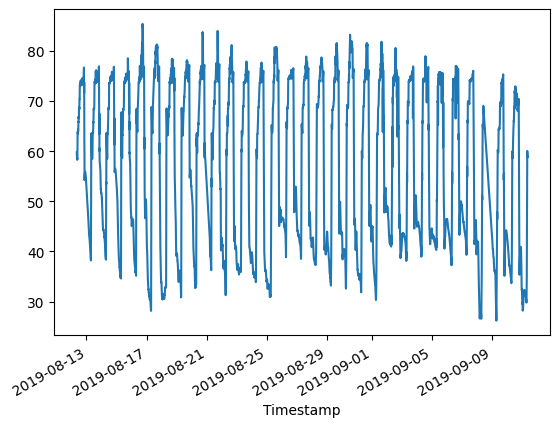

In [10]:
xtrain_dfs['inv_0']['TmpStk2_Igbt_PhsA_Bot'].plot()

<Axes: xlabel='Timestamp'>

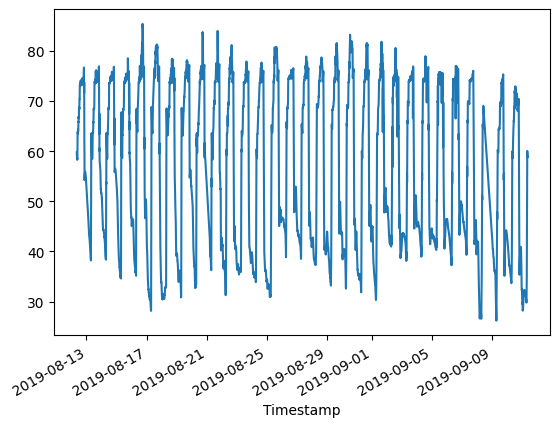

In [16]:
xtrain_dfs['inv_0']['TmpStk2_Igbt_PhsA_Bot'].plot()

<Axes: xlabel='Timestamp'>

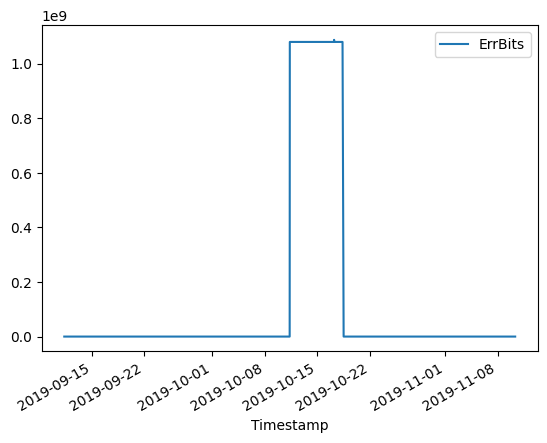

In [12]:
ytest_dfs['inv_0'].plot()